In [1]:
import numpy as np
import pandas as pd
import sys
import json
import os
import copy
import matplotlib.pyplot as plt
import scipy
import multiprocessing
import h5py
import corner

Make `WMPL` directory visible:

In [2]:
sys.path.append('../../')

Import WMPL files:

In [3]:
import source.WesternMeteorPyLib.wmpl.MetSim.MetSim as metsim
import source.WesternMeteorPyLib.wmpl.MetSim.FitSim as fitsim
import source.WesternMeteorPyLib.wmpl.MetSim.GUI as gui
import source.WesternMeteorPyLib.wmpl.MetSim.MetSimErosion as erosion

Modified version to run with the optimization routine:

In [4]:
class MetSimObj():
    def __init__(self, traj_path, const_json_file, fixed_frag_indices, free_frag_indices, er_frag_indices):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()  # initialize this, these will be replaced later
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # get global parameters from json file, everything other than params marked "free" are fixed
        dt = const_json.get('dt')
        P_0m = const_json.get('P_0m')
        h_init = const_json.get('h_init')
        m_kill = const_json.get('m_kill')
        v_kill = const_json.get('v_kill')
        h_kill = const_json.get('h_kill')
        len_kill = const_json.get('len_kill') 
        rho = const_json.get('rho')  # free
        rho_grain = const_json.get('rho_grain')  # free
        m_init = const_json.get('m_init')  # free
        sigma = const_json.get('sigma')  # free
        v_init = const_json.get('v_init')
        shape_factor = const_json.get('shape_factor')
        gamma = const_json.get('gamma')
        zenith_angle = const_json.get('zenith_angle')
        lum_eff = const_json.get('lum_eff')
        lum_eff_type = const_json.get('lum_eff_type')
        erosion_height_start = const_json.get('erosion_height_start')
        erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
        erosion_coeff = const_json.get('erosion_coeff')
        erosion_height_change = const_json.get('erosion_height_change')
        erosion_coeff_change = const_json.get('erosion_coeff_change')
        erosion_mass_index = const_json.get('erosion_mass_index')
        erosion_mass_min = const_json.get('erosion_mass_min')
        erosion_mass_max = const_json.get('erosion_mass_max')
        erosion_rho_change = const_json.get('rho')
        erosion_sigma_change = const_json.get('sigma')
        compressive_strength = const_json.get('compressive_strength')
        disruption_erosion_coeff = const_json.get('erosion_coeff')
        disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
        disruption_mass_index = const_json.get('disruption_mass_index')
        disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
        disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')

        # get fragmentation parameters from json file
        # type, height, number, gamma, mass index are fixed, 
        # mass, ablation coefficient, erosion coefficient, grain min, grain max are not fixed
        num_frags = len(const_json.get('fragmentation_entries'))
        # fixed
        frag_types = []
        frag_numbers = []
        frag_ab_coeffs = []
        frag_gammas = []
        frag_mis = []
        # free
        frag_masses = []
        frag_er_coeffs = []
        frag_grain_mins = []
        frag_grain_maxs = []
        frag_heights = []

        # set free and fixed params
        #### CHANGE THESE LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
        self.fixed_frag_indices = fixed_frag_indices
        self.free_frag_indices = free_frag_indices
        self.er_frag_indices = er_frag_indices
        # set up masks for free and fixed indices
        # free
        free_frag_mask = np.zeros(num_frags, bool)
        free_frag_mask[free_frag_indices] = True  # only free frags
        # fixed
        fixed_frag_mask = np.ones(num_frags, bool)
        fixed_frag_mask[free_frag_indices] = False  # everything EXCEPT free frags (i.e. fixed frags)
        # erosion
        er_frag_mask = np.zeros(num_frags, bool)
        er_frag_mask[er_frag_indices] = True  # only frags that have erosion coefficients (i.e. all free fragments excluding dust)
        
        for i, frag in enumerate(const_json.get('fragmentation_entries')):
            ### If sigma, gamma and erosiion coefficient are none, convert to whatever the default value is 
            # fixed
            frag_types.append(frag['frag_type'])
            frag_numbers.append(frag['number'])
            if frag['gamma'] == None:
                frag_gammas.append(gamma)
            else:
                frag_gammas.append(frag['gamma'])
            frag_mis.append(frag['mass_index'])
            if frag['sigma'] == None:
                frag_ab_coeffs.append(sigma) 
            else:
                frag_ab_coeffs.append(frag['sigma'])
            # free
            frag_masses.append(frag['mass_percent'])
            if frag['erosion_coeff'] == None:  # this means that the fragment is dust
                frag_er_coeffs.append(0.)  # erosion coefficient of zero
            else:
                frag_er_coeffs.append(frag['erosion_coeff'])
            frag_grain_mins.append(frag['grain_mass_min'])
            frag_grain_maxs.append(frag['grain_mass_max'])
            frag_heights.append(frag['height'])

        # fixed_frag_mask = np.argsort(fixed_frag_mask)
        # assign free fixed parameters to object
        self.free_params = [m_init, 
                            list(np.array(frag_masses)[free_frag_mask]), 
                            list(np.array(frag_er_coeffs)[er_frag_mask]),  # use er frag mask for this one! 
                            list(np.array(frag_grain_mins)[free_frag_mask]), 
                            list(np.array(frag_grain_maxs)[free_frag_mask]),
                            list(np.array(frag_heights)[free_frag_mask])  # heights
                           ]
        self.fixed_params = [dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, 
                             v_init, shape_factor, 
                            gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, 
                            erosion_bins_per_10mass, erosion_coeff, erosion_height_change, 
                            erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, 
                            erosion_rho_change, erosion_sigma_change, compressive_strength, 
                            disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, 
                            disruption_mass_min_ratio, disruption_mass_max_ratio, 
                            frag_types, frag_numbers, 
                            frag_ab_coeffs, frag_gammas, frag_mis,
                            list(np.array(frag_masses)[fixed_frag_mask]), 
                            list(np.array(frag_er_coeffs)[~er_frag_mask]),  # and inverse of er frag mask 
                            list(np.array(frag_grain_mins)[fixed_frag_mask]), 
                            list(np.array(frag_grain_maxs)[fixed_frag_mask]),
                            list(np.array(frag_heights)[fixed_frag_mask])
                            ]
        
        # load all the global parameters into the object
        consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
        self.loadGlobalParameters(consts)

        # get all parameters
        self.all_params = (self.free_params, self.fixed_params)
        
        # self.initializeSimulation(all_params)
        # self.initializeSimulation(const_json)
    
    def loadGlobalParameters(self, consts):
            """
            Loads the global parameters (constants) into the object
            """
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio = consts
            # load all the non-fragmentation parameters into the object
            # 33 parameters
            self.const.dt = dt
            self.const.P_0m = P_0m
            self.const.h_init = h_init
            self.const.m_kill = m_kill
            self.const.v_kill = v_kill
            self.const.h_kill = h_kill
            self.const.len_kill = len_kill
            self.const.rho = rho
            self.const.rho_grain = rho_grain
            self.const.m_init = m_init
            self.const.sigma = sigma
            self.const.v_init = v_init
            self.const.shape_factor = shape_factor
            self.const.gamma = gamma
            self.const.zenith_angle = zenith_angle
            self.const.lum_eff = lum_eff
            self.const.lum_eff_type = lum_eff_type
            self.const.erosion_height_start = erosion_height_start
            self.const.erosion_bins_per_10mass = erosion_bins_per_10mass
            self.const.erosion_coeff = erosion_coeff
            self.const.erosion_height_change = erosion_height_change
            self.const.erosion_coeff_change = erosion_coeff_change
            self.const.erosion_mass_index = erosion_mass_index
            self.const.erosion_mass_min = erosion_mass_min
            self.const.erosion_mass_max = erosion_mass_max
            self.const.erosion_rho_change = erosion_rho_change
            self.const.erosion_sigma_change = erosion_sigma_change
            self.const.compressive_strength = compressive_strength
            self.const.disruption_erosion_coeff = disruption_erosion_coeff
            self.const.disruption_mass_grain_ratio = disruption_mass_grain_ratio
            self.const.disruption_mass_index = disruption_mass_index
            self.const.disruption_mass_min_ratio = disruption_mass_min_ratio
            self.const.disruption_mass_max_ratio = disruption_mass_max_ratio

    def initializeSimulation(self, all_params):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            # if self.const.fragmentation_on and (self.fragmentation is None):
            #     frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
            #         "Fragmentation is enabled but no fragmentation file is set.")
            #     frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
            #     frag_error_message.exec_()
            #     return None   

            # unpack all params
            free_params, fixed_params = all_params
            # unpack again
            #### CHANGE THESE NEXT TWO LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
            m_init, frag_masses_free, frag_er_coeffs_free, frag_grain_mins_free, frag_grain_maxs_free, frag_heights_free = free_params 
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio, frag_types, frag_numbers, frag_ab_coeffs, frag_gammas, frag_mis, frag_masses_fixed, frag_er_coeffs_fixed, frag_grain_mins_fixed, frag_grain_maxs_fixed, frag_heights_fixed = fixed_params
            # load all the global parameters into the object
            consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
            self.loadGlobalParameters(consts)
            # combine free fixed fragmentation parameters
            frag_order = np.argsort(self.fixed_frag_indices + self.free_frag_indices)
            frag_masses = np.concatenate((frag_masses_fixed, frag_masses_free))[frag_order]
            frag_er_coeffs = np.zeros(len(frag_masses))  # number of fragments
            frag_er_coeffs[self.er_frag_indices] = frag_er_coeffs_free  # set all erosion fragments to their values, everything else is zero
            frag_grain_mins = np.concatenate((frag_grain_mins_fixed, frag_grain_mins_free))[frag_order]
            frag_grain_maxs = np.concatenate((frag_grain_maxs_fixed, frag_grain_maxs_free))[frag_order]
            frag_heights = np.concatenate((frag_heights_fixed, frag_heights_free))[frag_order]

            # print(frag_order, np.concatenate((frag_masses_fixed, frag_masses_free)), frag_masses)
            
            # Load fragmentation entries
            self.fragmentation_entries = []
            for i in range(0, len(frag_masses)):  # pick any frag entry to iterate over
                frag_entry = gui.FragmentationEntry(frag_types[i], frag_heights[i], frag_numbers[i], frag_masses[i], 
                                                    frag_ab_coeffs[i], frag_gammas[i], frag_er_coeffs[i], frag_grain_mins[i], frag_grain_maxs[i], frag_mis[i])
                self.fragmentation_entries.append(frag_entry)
            # set the fragmentation entries to constants
            self.const.fragmentation_entries = self.fragmentation_entries
    
            # Sort entries by height
            self.fragmentation.sortByHeight()

            # Reset the status of all fragmentations
            self.fragmentation.resetAll()
        
            # fragmentation
            self.const.fragmentation_on = True

            # print(self.const.fragmentation_on)
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            # print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)


Test with event:

In [5]:
# metsim_obj_old = MetSimObj_old(traj_path='../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', 
#                        const_json_file='../usg_metsim_files/1999-01-14/usg_input_jan_1999_sim_fit_latest.json')

In [6]:
event_path = '../usg_metsim_files/non_decameter/almahatta_sitta/usg_input_almahatta_sitta'

FIXED_FRAG_INDICES = []
FREE_FRAG_INDICES = [0, 1, 2, 3, 4]#, 5]#, 6]#, 6, 7, 8]  # fragments with free parameters
ER_FRAG_INDICES = [0, 1, 2, 3, 4]#, 5, 6]#, 2, 3, 4]  # free fragments that have erosion coefficients (i.e. all free fragments excluding dust)

metsim_obj = MetSimObj(traj_path=event_path + '.txt', 
                       const_json_file=event_path + '_sim_fit_latest.json',
                       fixed_frag_indices = FIXED_FRAG_INDICES,
                       free_frag_indices = FREE_FRAG_INDICES,
                       er_frag_indices = ER_FRAG_INDICES
                      )
# initialize simulation, run with all parameters
metsim_obj.initializeSimulation(metsim_obj.all_params)

/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:1563: RuntimeWarning: invalid value encountered in log10
  data.absolute_magnitudes = -2.5*np.log10(data.usg_intensity_data[:, 1]/248)
/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:95: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_main = -2.5*np.log10(self.luminosity_main_arr/self.const.P_0m)
/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:99: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_eroded = -2.5*np.log10(self.luminosity_eroded_arr/self.const.P_0m)


(10.0, 80.0)

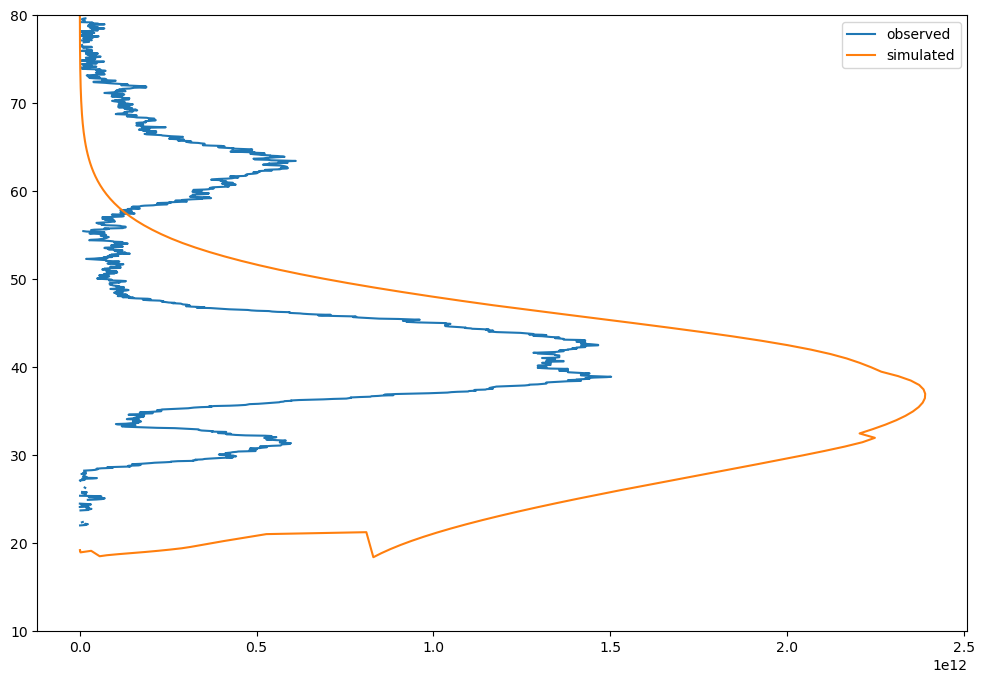

In [7]:
plt.figure(figsize = (12, 8))
plt.plot(3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5))), metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.plot(metsim_obj.simulation_results.luminosity_arr, metsim_obj.simulation_results.leading_frag_height_arr/1000., label = 'simulated')
plt.legend()
plt.ylim(10., 80.)

In [8]:
# plt.figure(figsize = (12, 8))
# plt.plot(metsim_obj_old.usg_data.time_data + 11.9, metsim_obj_old.usg_data.absolute_magnitudes, label = 'observed')
# plt.plot(metsim_obj_old.simulation_results.time_arr, metsim_obj_old.simulation_results.abs_magnitude, label = 'simulated')
# plt.legend()

In [9]:
# plt.figure(figsize = (12, 8))
# plt.plot(metsim_obj_old.usg_data.time_data + 11.9, 3030 * (10 ** (metsim_obj_old.usg_data.absolute_magnitudes/(-2.5))), label = 'observed')
# plt.plot(metsim_obj_old.simulation_results.time_arr, metsim_obj_old.simulation_results.luminosity_arr, label = 'simulated')
# plt.legend()
# plt.plot()

In [10]:
# check observed - simulated integrated intensity

obs_integrated_intensity = np.nansum(np.diff(metsim_obj.usg_data.time_data) * 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))[1:])
sim_integrated_intensity = np.nansum(np.diff(metsim_obj.simulation_results.time_arr) * metsim_obj.simulation_results.luminosity_arr[1:])

obs_integrated_intensity, sim_integrated_intensity

(1642623358821.774, 4845614119509.922)

In [11]:
obs_integrated_intensity - sim_integrated_intensity

-3202990760688.148

### Optimization:

Note that sometimes MetSim returns a simulated LC in which the height of the leading fragment increases after the end of the LC

In [12]:
# helper nested function to flatten a list

def flatten_list(nested_list):
    def flatten(lst):
        for item in lst:
            if isinstance(item, list):
                flatten(item)
            else:
                flat_list.append(item)

    flat_list = []
    flatten(nested_list)
    return flat_list

# helper function to unflatten the list
#### CHANGE THE NUMBER OF GLOBAL/FRAGMENT PARAMETERS TO TEST DIFFERENT COMBINATIONS
def unflatten_list(lst, num_global_params=1, num_frag_params=5, er_frag_indices=ER_FRAG_INDICES):
    """
    change number of global parameters and frag parameters based on the structure of the free parameters object
    passed into the get_lc_cost_function() function
    """
    # print(lst[:num_global_params], list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params))))
    num_frag_params = max(1, num_frag_params)
    sizes = list(np.repeat('k', num_frag_params - 1))
    sizes.insert(0, int(num_global_params))
    sizes.insert(2, int(len(er_frag_indices)))  # CHANGE THESE INDICES IF STRUCTURE CHANGES
    k = (len(lst) - sum(s for s in sizes if s != 'k')) // sizes.count('k') if 'k' in sizes else 0
    result, index = [], 0
    for size in sizes:
        group_size = k if size == 'k' else size
        if group_size == 1:
            result.append(lst[index])
        else:
            result.append(lst[index:index + group_size])
        index += group_size
    return result
       
    # else:
    #     return list(lst[:num_global_params]) + list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params)))


### define residuals for the optimization routine
# TODO: make sure the two are the same size


# def get_lc_residuals(free_params_flattened, metsim_obj):
#     """
#     Gets the residuals for the integrated intensity given a flattened list of free parameters and a metsim object

#     Flattened list of free parameters has the form
#     free_params = [rho, rho_grain, m_init, sigma, *frag_masses, *frag_ab_coeffs, *frag_er_coeffs, *frag_grain_mins, *frag_grain_maxs]

#     Global parameters:
#     rho: float
#     rho_grain: float
#     m_init: float
#     sigma: float

#     Fragment parameters (for n total fragments):
#     *frag_masses: n fragment masses
#     *frag_ab_coeffs: n ablation coefficients
#     *frag_er_coeffs: n erosion coefficients
#     *frag_grain_mins: n grain mins
#     *frag_grain_maxs: n grain maxs
#     """
#     # observed integrated intensity, this doesn't change
#     obs_integrated_intensity = np.nansum(np.diff(metsim_obj.usg_data.time_data) * 
#                                          3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))[1:])
#     # compute the simulated integrated intensity for the given set of free parameters
#     # unflatten the list of free parameters to pass into the initializeSimulation() function
#     free_params = unflatten_list(free_params_flattened)
#     # construct all params to pass into intiializeSimulation function
#     all_params = (free_params, metsim_obj.fixed_params)  # set of all params to use
#     # run simulation
#     metsim_obj.initializeSimulation(all_params)
    
#     # get simulated integrated intensity
#     sim_integrated_intensity = np.nansum(np.diff(metsim_obj.simulation_results.time_arr) * 
#                                          metsim_obj.simulation_results.luminosity_arr[1:])
#     # return the difference between the two
#     return (obs_integrated_intensity - sim_integrated_intensity)

### get the simulated light curve for a given set of free parameters and metsim object

def sim_lc(flattened_free_params, metsim_obj):
    """
    Same format as function below
    """
    # compute the simulated integrated intensity for the given set of free parameters
    # unflatten the list of free parameters to pass into the initializeSimulation() function
    free_params = unflatten_list(list(flattened_free_params))
    # construct all params to pass into intiializeSimulation function
    # print(free_params)
    all_params = (free_params, metsim_obj.fixed_params)  # set of all params to use
    # run simulation on the object, copying it
    # obj_copy = copy.copy(metsim_obj)
    # obj_copy.initializeSimulation(all_params)
    metsim_obj.initializeSimulation(all_params)
    # return the simulation results
    # return obj_copy.simulation_results
    return metsim_obj.simulation_results


### define cost function for the opitmization routine

def get_lc_cost_function(flattened_free_params, metsim_obj, pso=False):
    """
    Gets the residuals for the integrated intensity given
    a metsim object and a list/tuple of an initial guess of free parameters
    
    metsim_obj is an MetSim() object
    flattened_free_params is an initial guess flattened list of free parameters with the form
    flattened_free_params = [rho, rho_grain, m_init, sigma, *frag_masses, 
    *frag_ab_coeffs, *frag_er_coeffs, *frag_grain_mins, *frag_grain_maxs]
    pso is a boolean for if pso is being used

    Global parameters:
    rho: float
    rho_grain: float
    m_init: float
    sigma: float

    Fragment parameters (for n total fragments):
    *frag_masses: n fragment masses
    *frag_ab_coeffs: n ablation coefficients
    *frag_er_coeffs: n - nd erosion coefficients where nd is the number of dust fragments
    (as dust fragments do not have a nassociated erosion coefficient)
    *frag_grain_mins: n grain mins
    *frag_grain_maxs: n grain maxs
    """
    # print(f'parameters: {flattened_free_params}')
    # observed LC intensity, this doesn't change
    obs_lc_intensity = 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))

    # get simulated LC intensity onthe object
    # flatten if pso is being used
    if pso:
        flattened_free_params = flattened_free_params.flatten()
    simulation_results = sim_lc(flattened_free_params, metsim_obj)
    # compute simulated LC intensity
    # find where height starts increasing if it does at any point
    # print(np.diff(simulation_results.leading_frag_height_arr))
    if np.sum(np.diff(simulation_results.leading_frag_height_arr) > 0) > 0:
        first_increasing_height_arr = np.where(np.diff(simulation_results.leading_frag_height_arr) > 0)[0][0] - 1
        # print('increasing height')
    else:
        first_increasing_height_arr = -1
    # interpolate to make sure they are the same length and discard points after height starts increasing if it does at any point
    simulated_lc_intensity = np.interp(metsim_obj.traj.observations[0].model_ht, 
                                       np.flip(simulation_results.leading_frag_height_arr[:first_increasing_height_arr]), 
                                       np.flip(simulation_results.luminosity_arr[:first_increasing_height_arr]))
    # return the negative log-likelihood (negative residual sum of square difference between the two)
    # assuming there is no error for the observed LC data
    # print(len(obs_lc_intensity), len(simulated_lc_intensity))
    log_likelihood = (-1/2 * np.nansum((obs_lc_intensity - simulated_lc_intensity) ** 2))/1e24  # scale this
    # print(f'negative logL: {-log_likelihood}')
    # negative log lieklihood
    return -log_likelihood

Also need to make sure that the loss function to minimize (currently computed as the **negative** log-likelihood equivalent to negative RSS/$\chi^2$) is correct, since if there are errors then these need to be accounted for in the computation of the loss function

Also probably want to make `sim_lc` returns the interpolated LC:

Test to make sure changing the parameters affects the logL and the LCs:

In [13]:
metsim_obj.free_params

[1000000.0,
 [85.0, 10.0, 10.0, 10.0, 10.0],
 [8.3e-06, 5.33e-06, 5.33e-06, 5.33e-06, 5.33e-06],
 [0.1, 0.1, 0.1, 0.1, 0.1],
 [0.5, 5.0, 5.0, 5.0, 5.0],
 [83000.0, 55000.0, 48000.0, 40000.0, 33000.0]]

In [14]:
# # # USE FOLLOWING LINE TO SAVE NEW SET OF TEST PARAMETERS WHEN TESTING DIFFERENT COMBINATIONS OF PARAMETERS
# np.save('initial_guesses/initial_guess_2013_02_15_TEST_heights.npy', np.array(flatten_list(metsim_obj.free_params)))
# # # and to save
# # # np.save('initial_guess_2004_10_07_TEST_edited.npy', pos)

In [14]:
initial_guess = np.load('initial_guesses/initial_guess_almahatta_sitta_TEST_heights.npy')  # initial pre-saved guess
# initial_guess

lamb_func = lambda free_params_flattened: get_lc_cost_function(free_params_flattened, metsim_obj=metsim_obj, pso=False)
lamb_func(initial_guess)

/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:95: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_main = -2.5*np.log10(self.luminosity_main_arr/self.const.P_0m)
/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:99: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_eroded = -2.5*np.log10(self.luminosity_eroded_arr/self.const.P_0m)


538.9467398988478

In [15]:
initial_guess

array([1.00e+06, 8.50e+01, 1.00e+01, 1.00e+01, 1.00e+01, 1.00e+01,
       8.30e-06, 5.33e-06, 5.33e-06, 5.33e-06, 5.33e-06, 1.00e-01,
       1.00e-01, 1.00e-01, 1.00e-01, 1.00e-01, 5.00e-01, 5.00e+00,
       5.00e+00, 5.00e+00, 5.00e+00, 8.30e+04, 5.50e+04, 4.80e+04,
       4.00e+04, 3.30e+04])

In [17]:
#### USE THIS TO TEST DIFFERENT COMBINATIONS OF TEST PARAMETERS

initial_guess_mod = initial_guess.copy()
# fiddle with global mass
initial_guess_mod[0] = initial_guess[0]
# fiddle with frag masses
initial_guess_mod = initial_guess + [0., # total mass
                                     0., 0., 0., 0., 0.,# 0.,# 0.,   # frag mass pcts
                                     0., 0., 0., 0., 0.,#  0., 1.e-8,  # erosion coeffs
                                     0., 0., 0., 0., 0.,# 0.,# 0.,  # grain mins
                                     0., 0., 0., 0., 0.,# 0.,# 0.,   # grain maxs
                                     0., 1000., 0., 0., 0.,# 0.,# 0., # heights
                                    ] 
# initial_guess_mod = initial_guess + np.zeros(1 + 4 * len(FREE_FRAG_INDICES))

In [18]:
lamb_func(initial_guess_mod)

538.7752321380682

In [19]:
results_initial = sim_lc(initial_guess, metsim_obj)
results_initial_mod = sim_lc(initial_guess_mod, metsim_obj)

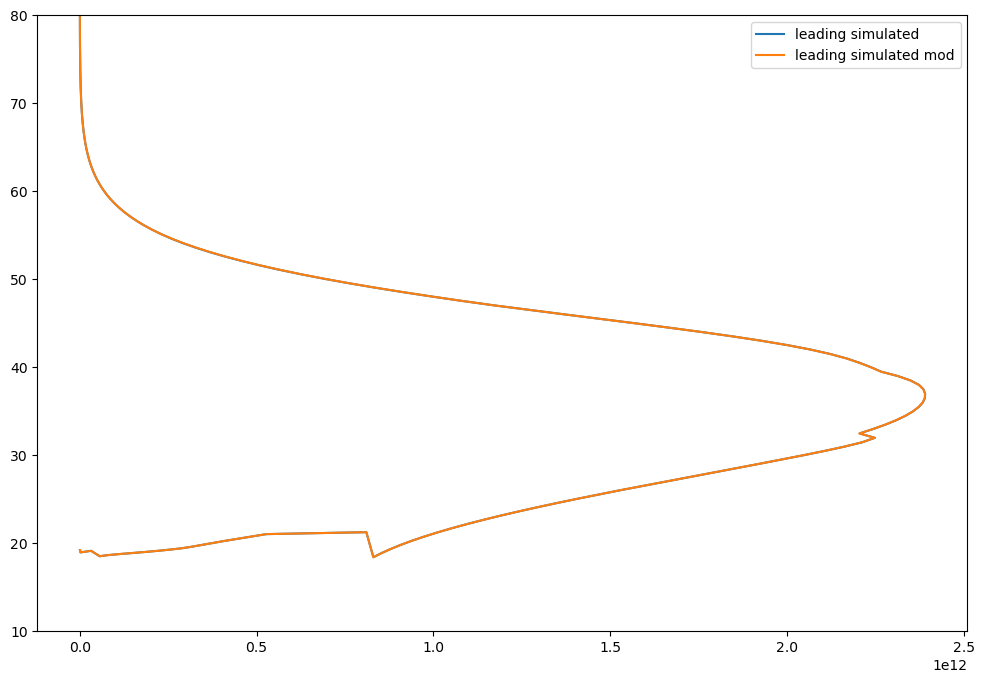

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
# plt.plot(results_bf.luminosity_arr, results_bf.leading_frag_height_arr/1000., label = 'best fit')
# plt.plot(interpolated_bf_intensity, metsim_obj.traj.observations[0].model_ht/1000., label = 'best fit')
plt.plot(results_initial_mod.luminosity_arr, results_initial_mod.leading_frag_height_arr/1000., label = 'leading simulated mod')
plt.ylim(10., 80.)
plt.legend()

Compute observed LC and simulated initial guess:

In [21]:
# observed LC intensity
obs_lc_intensity = 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))
# simulated LC intensities
# initial
results_initial = sim_lc(initial_guess, metsim_obj)

Plot simulated initial guess versus observed magnitudes and intensities:

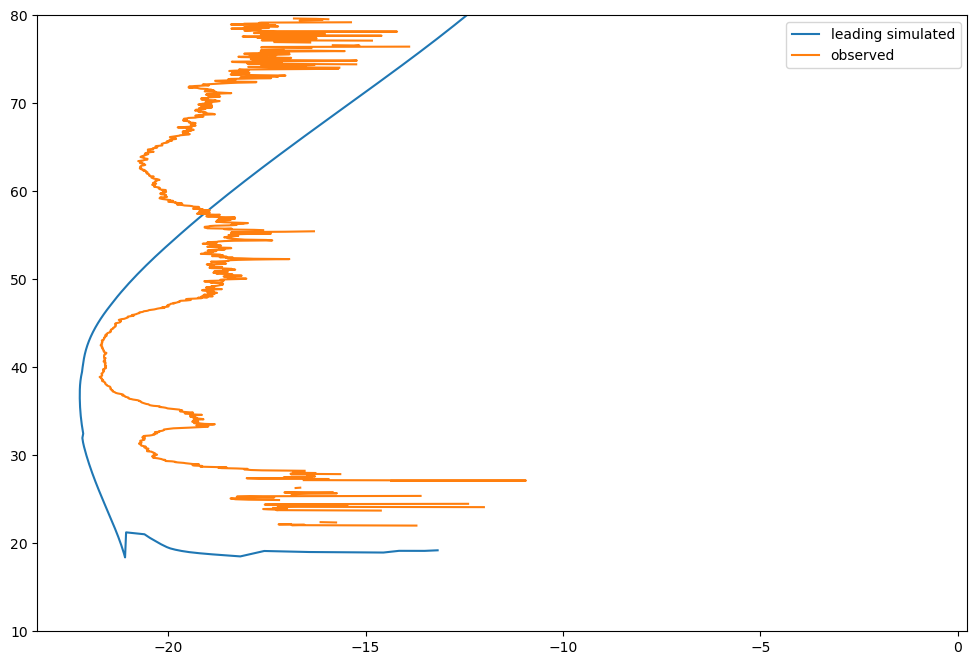

In [22]:
plt.figure(figsize = (12, 8))
plt.plot(results_initial.abs_magnitude, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
plt.plot(metsim_obj.usg_data.absolute_magnitudes, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.ylim(10., 80.)
plt.legend()

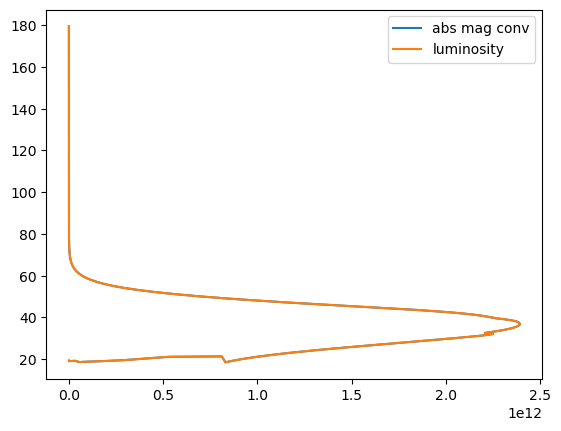

In [23]:
plt.plot(3030 * (10 ** (results_initial.abs_magnitude/(-2.5))), results_initial.leading_frag_height_arr/1000., label = 'abs mag conv')
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'luminosity')
plt.legend()

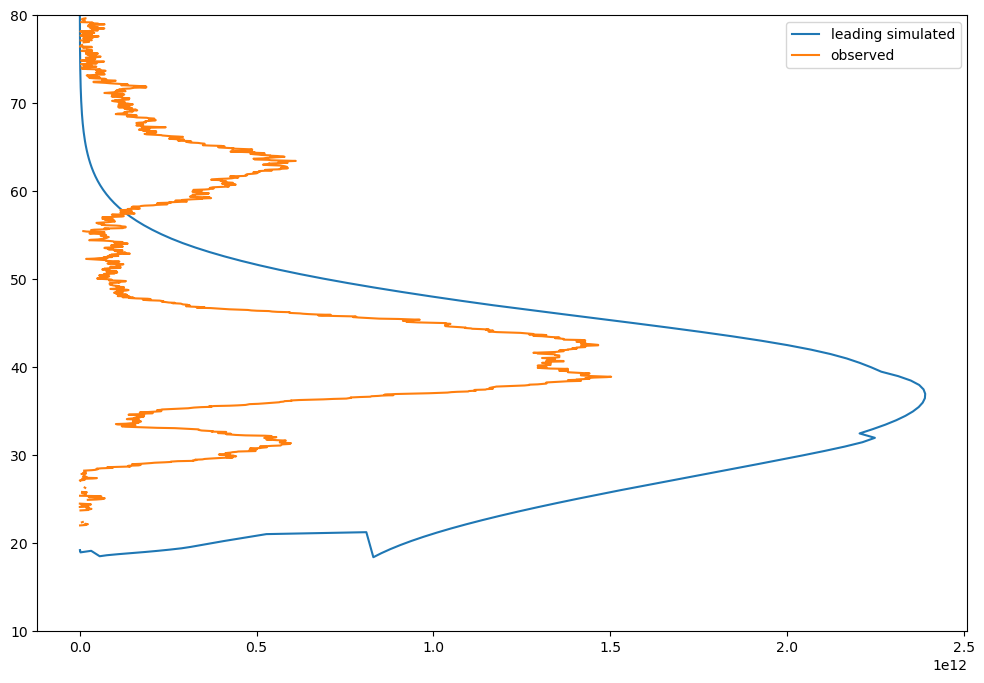

In [24]:
plt.figure(figsize = (12, 8))
# plt.plot(results_initial.luminosity_arr, results_initial.main_height_arr/1000., label = 'main')
# plt.plot(results_initial.luminosity_arr, results_initial.brightest_height_arr/1000., label = 'brightest')
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
plt.plot(obs_lc_intensity, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.ylim(10., 80.)
plt.legend()

NS comparison:

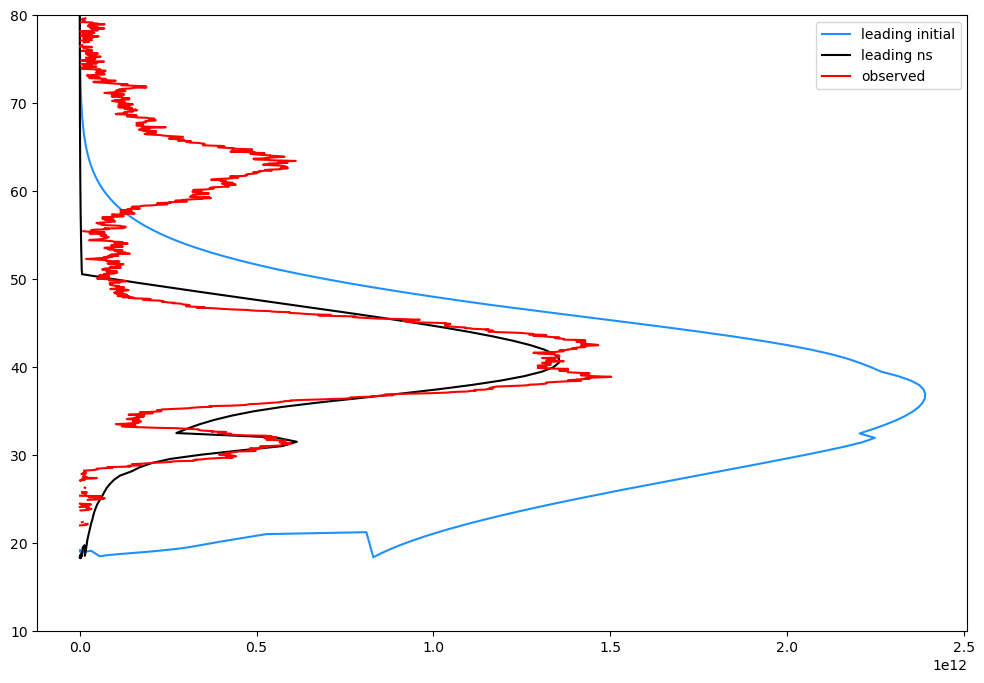

In [25]:
ns_best = np.array([2.72387392e+05, 6.58427621e-01, 9.17855082e+01, 3.90077476e+00,
        1.67062634e+00, 9.38966275e+01, 3.15597183e-06, 3.53896265e-06,
        1.44948370e-06, 9.36234560e-06, 1.93799553e-06, 5.04066579e+01,
        1.55421423e-04, 5.30722747e+01, 4.22333005e+00, 1.58131316e-04,
        1.04142551e+02, 2.48417823e+03, 1.45004208e+03, 1.44002990e+03,
        3.19544374e+03, 8.25586702e+04, 5.15033090e+04, 4.65530828e+04,
        4.34880221e+04, 3.34531922e+04])

# ns
results_ns = sim_lc(ns_best, metsim_obj)

# Plot
plt.figure(figsize = (12, 8))
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading initial', color = 'dodgerblue')
plt.plot(results_ns.luminosity_arr, results_ns.leading_frag_height_arr/1000., label = 'leading ns', color = 'black')
plt.plot(obs_lc_intensity, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed', color = 'red')
plt.ylim(10., 80.)
plt.legend()

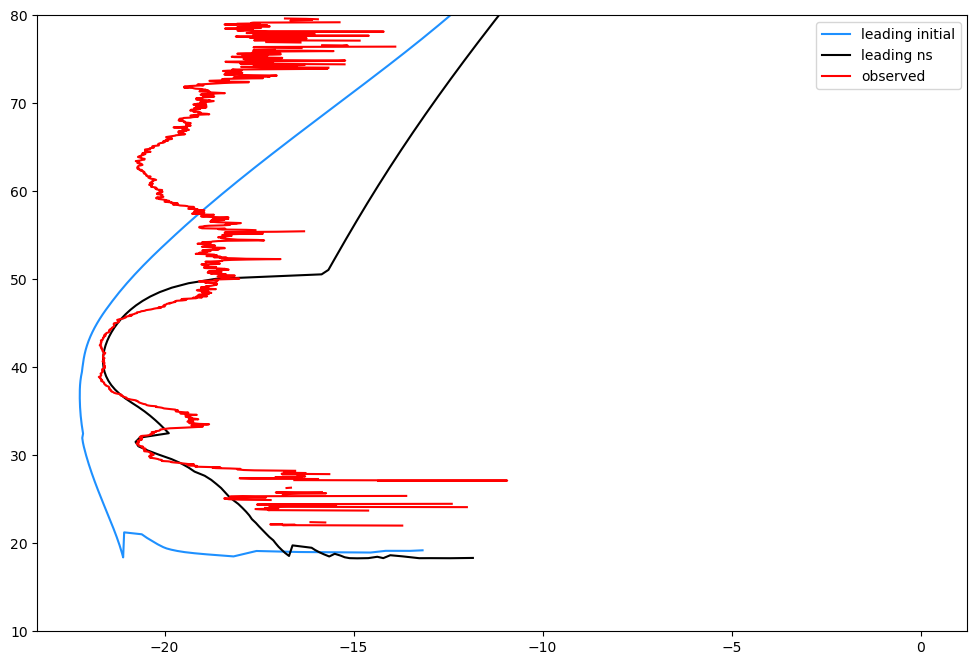

In [26]:
plt.figure(figsize = (12, 8))
plt.plot(results_initial.abs_magnitude, results_initial.leading_frag_height_arr/1000., label = 'leading initial', color = 'dodgerblue')
plt.plot(results_ns.abs_magnitude, results_ns.leading_frag_height_arr/1000., label = 'leading ns', color = 'black')
plt.plot(metsim_obj.usg_data.absolute_magnitudes, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed', color = 'red')
plt.ylim(10., 80.)
plt.legend()

## NS:

Uniform bounds:

In [27]:
# Generate the tuples based on the length of free fragments
fragmentation_count = len(FREE_FRAG_INDICES)
# Fragment mass percents
frag_mass_percents = tuple((0., 100.) for _ in range(fragmentation_count))
# Frag ablation coeffs
# these are 0.01 for dust and between (0.002 * 1e-6, 0.025 * 1e-6) for eroding fragments
# frag_ablation_coeffs = tuple((0.002 * 1e-6, 0.025 * 1e-6) for _ in range(fragmentation_count))
# frag_ablation_coeffs = tuple([(0.01 * 1e-6, 0.01 * 1e-6) if entry.frag_type == 'D'
#                               else (0.002 * 1e-6, 0.025 * 1e-6) for entry in metsim_obj.fragmentation_entries])
# Frag erosion coeffs
# these are fixed at zero for dust and between (0.23 * 1e-6, 6.0 * 1e-6) for eroding fragments
# frag_erosion_coeffs = tuple([(0., 0.) if entry.frag_type == 'D' 
#                              else (0.23 * 1e-6, 6.0 * 1e-6) for entry in metsim_obj.fragmentation_entries])
# keep lower bound above 0.1e6 because that's where the initial guess is
frag_erosion_coeffs = tuple([(0.05 * 1e-6, 10.0 * 1e-6) for entry in 
                             [metsim_obj.fragmentation_entries[i] for i in ER_FRAG_INDICES]])
# frag_erosion_coeffs = tuple((0.23 * 1e-6, 6.0 * 1e-6) for _ in range(fragmentation_count))
# Frag grain mins
# frag_grain_mins = tuple((1e-8, 1e-2) for _ in range(fragmentation_count))
frag_grain_mins = tuple((1e-4, 1e2) for _ in range(fragmentation_count))
# Frag grain maxs
frag_grain_maxs = tuple((1e-3, 1e4) for _ in range(fragmentation_count))
# Frag heights
frag_heights = tuple((20., 80.) for _ in range(fragmentation_count))
# Combine them into a single flat tuple
#### CHANGE THE RESULTS/BOUNDS DEPENDING ON WHAT COMBINATION IS BEING USED!
result = frag_mass_percents + frag_erosion_coeffs + frag_grain_mins + frag_grain_maxs + frag_heights
# Print the result to check the output
hard_bounds = np.array(((1.e4, 1.e8), ) + result)

In [28]:
hard_bounds

array([[1.e+04, 1.e+08],
       [0.e+00, 1.e+02],
       [0.e+00, 1.e+02],
       [0.e+00, 1.e+02],
       [0.e+00, 1.e+02],
       [0.e+00, 1.e+02],
       [5.e-08, 1.e-05],
       [5.e-08, 1.e-05],
       [5.e-08, 1.e-05],
       [5.e-08, 1.e-05],
       [5.e-08, 1.e-05],
       [1.e-04, 1.e+02],
       [1.e-04, 1.e+02],
       [1.e-04, 1.e+02],
       [1.e-04, 1.e+02],
       [1.e-04, 1.e+02],
       [1.e-03, 1.e+04],
       [1.e-03, 1.e+04],
       [1.e-03, 1.e+04],
       [1.e-03, 1.e+04],
       [1.e-03, 1.e+04],
       [2.e+01, 8.e+01],
       [2.e+01, 8.e+01],
       [2.e+01, 8.e+01],
       [2.e+01, 8.e+01],
       [2.e+01, 8.e+01]])

More restrictive bounds

In [29]:
# initialize particles
cov_factor = 1.e-1  # CHANGE THIS DEPENDING ON THE EVENT
cov = np.float64(np.diag(np.ones(len(initial_guess)) * (initial_guess ** 2))) * cov_factor
# cov = np.eye(len(initial_guess), len(initial_guess)) * cov_factor
mu = initial_guess
bounds = tuple([tuple(np.clip((mu[i] - 2. * np.diag(np.sqrt(cov))[i], mu[i] + 2. * np.diag(np.sqrt(cov))[i]), 
                        hard_bounds[i][0], hard_bounds[i][1])) for i in range(0, len(mu))])

# manually change certain bounds
bounds = np.array(bounds)
bounds[0] = (1.e4, 1.e8)
bounds[1:len(frag_mass_percents) + 1] = np.repeat([(0., 100.)], len(frag_mass_percents), axis=0)
height_bounds = 1000.  # permissible values plus or minus the starting fragmentation height
bounds[-fragmentation_count:] = np.array((initial_guess[-fragmentation_count:] - height_bounds, 
                                                         initial_guess[-fragmentation_count:] + height_bounds)).T
bounds = tuple([tuple(bound) for bound in bounds])

In [30]:
bounds

((10000.0, 100000000.0),
 (0.0, 100.0),
 (0.0, 100.0),
 (0.0, 100.0),
 (0.0, 100.0),
 (0.0, 100.0),
 (3.05061908412049e-06, 9.999999999999999e-06),
 (1.9590120142605075e-06, 8.700987985739493e-06),
 (1.9590120142605075e-06, 8.700987985739493e-06),
 (1.9590120142605075e-06, 8.700987985739493e-06),
 (1.9590120142605075e-06, 8.700987985739493e-06),
 (0.03675444679663241, 0.1632455532033676),
 (0.03675444679663241, 0.1632455532033676),
 (0.03675444679663241, 0.1632455532033676),
 (0.03675444679663241, 0.1632455532033676),
 (0.03675444679663241, 0.1632455532033676),
 (0.18377223398316206, 0.816227766016838),
 (1.8377223398316205, 8.16227766016838),
 (1.8377223398316205, 8.16227766016838),
 (1.8377223398316205, 8.16227766016838),
 (1.8377223398316205, 8.16227766016838),
 (82000.0, 84000.0),
 (54000.0, 56000.0),
 (47000.0, 49000.0),
 (39000.0, 41000.0),
 (32000.0, 34000.0))

Run the optimization procedure on each segment of the light curve:

Set up NS with a uniform prior over all parameters (uses prior instead of log-prior, the log-likelihood is still the same):

In [191]:
import concurrent.futures
import signal

class TimeoutException(Exception):
    """Custom exception for timeouts."""
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Function execution timed out")


def gaussian_prior(cube, mu=mu, cov=cov, metsim_obj=metsim_obj, n_frags=fragmentation_count, er_frags=len(ER_FRAG_INDICES)):
    """
    Transform the unit cube to a multivariate Gaussian prior like the ball for MCMC

    mu is the vector of mean values
    cov is a covariance matrix
    """
    t = scipy.stats.norm.ppf(cube)  # transform cube to standard normal
    cube = mu + np.dot(np.sqrt(cov), t)  # correlate with appropriate mean and covariance
    

# PRIOR
def prior(cube, tup_bounds=bounds, n_frags=fragmentation_count, er_frags=len(ER_FRAG_INDICES)):
    """
    Transform the unit cube to a uniform prior
    """
    # bounds
    bounds = np.array(tup_bounds)
    mass_bnds = bounds[0]
    frag_mass_pct_bnds = bounds[1:n_frags + 1]
    frag_er_coeff_bnds = bounds[n_frags + 1: n_frags + er_frags + 1]
    frag_grain_min_bnds = bounds[n_frags + er_frags + 1: 2 * n_frags + er_frags + 1]
    frag_grain_max_bnds = bounds[2 * n_frags + er_frags + 1: 3 * n_frags + er_frags + 1]
    frag_height_bnds = bounds[3 * n_frags + er_frags + 1: 4 * n_frags + er_frags + 1]
    # particle params
    cube[0] = cube[0] * (mass_bnds[1] - mass_bnds[0]) + mass_bnds[0] # transform [0, 1] unit cube to [mass_lower, mass_uper]
    cube[1:n_frags + 1] = cube[1:n_frags + 1] * (frag_mass_pct_bnds[:, 1] - frag_mass_pct_bnds[:, 0]) + frag_mass_pct_bnds[:, 0]  # transform [0, 1] unit cube
    cube[n_frags + 1: n_frags + er_frags + 1] = cube[n_frags + 1: n_frags + er_frags + 1] * (frag_er_coeff_bnds[:, 1] - frag_er_coeff_bnds[:, 0]) + frag_er_coeff_bnds[:, 0]
    cube[n_frags + er_frags + 1: 2 * n_frags + er_frags + 1] = cube[n_frags + er_frags + 1: 2 * n_frags + er_frags + 1] * (frag_grain_min_bnds[:, 1] - frag_grain_min_bnds[:, 0]) + frag_grain_min_bnds[:, 0]
    cube[2 * n_frags + er_frags + 1: 3 * n_frags + er_frags + 1] = cube[2 * n_frags + er_frags + 1: 3 * n_frags + er_frags + 1] * (frag_grain_max_bnds[:, 1] - cube[n_frags + er_frags + 1: 2 * n_frags + er_frags + 1]) + cube[n_frags + er_frags + 1: 2 * n_frags + er_frags + 1]
    cube[3 * n_frags + er_frags + 1: 4 * n_frags + er_frags + 1] = cube[3 * n_frags + er_frags + 1: 4 * n_frags + er_frags + 1] * (frag_height_bnds[:, 1] - frag_height_bnds[:, 0]) + frag_height_bnds[:, 0]
    return cube

def run_with_timeout(func, timeout, *args, **kwargs):
    """
    Runs a function with a timeout using signal.
    Returns `nan` if the function exceeds the timeout.

    :param func: The function to execute.
    :param timeout: The maximum allowed execution time (in seconds).
    :param args: Positional arguments for the function.
    :param kwargs: Keyword arguments for the function.
    :return: The function's return value, or `nan` if it times out.
    """
    # Set the timeout handler
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)  # Start the timer
    try:
        result = func(*args, **kwargs)
    except TimeoutException:
        result = math.nan  # Return `nan` on timeout
    finally:
        signal.alarm(0)  # Cancel the alarm
    return result


def log_likelihood(particle, metsim_obj=metsim_obj, timeout=10):
    """
    similar to the get_lc_cost_function function but with positive instead of negative log-likelihood
    """
    # observed LC intensity, this doesn't change
    obs_lc_intensity = 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))

    # Set timeout handler
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)  # Start the timer for timeout
    # get simulated LC intensity onthe object
    try: 
        simulation_results = sim_lc(particle, metsim_obj)
    except TimeoutException:
        print('timeout')
        return -np.inf  # immediately return -np.inf if times out
    finally:
        signal.alarm(0)  # Cancel alarm
    # compute simulated LC intensity
    # find where height starts increasing if it does at any point
    # print(np.diff(simulation_results.leading_frag_height_arr))
    if np.sum(np.diff(simulation_results.leading_frag_height_arr) > 0) > 0:
        first_increasing_height_arr = np.where(np.diff(simulation_results.leading_frag_height_arr) > 0)[0][0] - 1
        # print('increasing height')
    else:
        first_increasing_height_arr = -1
    # interpolate to make sure they are the same length and discard points after height starts increasing if it does at any point
    simulated_lc_intensity = np.interp(metsim_obj.traj.observations[0].model_ht, 
                                       np.flip(simulation_results.leading_frag_height_arr[:first_increasing_height_arr]), 
                                       np.flip(simulation_results.luminosity_arr[:first_increasing_height_arr]))
    # return the negative log-likelihood (negative residual sum of square difference between the two)
    # assuming there is no error for the observed LC data
    # print(len(obs_lc_intensity), len(simulated_lc_intensity))
    log_likelihood = (-1/2 * np.nansum((obs_lc_intensity - simulated_lc_intensity) ** 2))/1.e24  # scale this
    # print(f'negative logL: {-log_likelihood}')
    # positive log lieklihood unlike get_lc_cost_function
    return log_likelihood


In [78]:
log_likelihood(np.array([7.00344845e+06, 
                         1.38801446e+01, 8.97753645e+01, 4.24916113e+01, 2.46375404e+01, 3.22921467e+01, 
                         6.57751856e-07, 2.39604768e-06, 5.32554045e-06, 1.33689115e-06, 
                         1.33209168e-02, 1.40022540e-04, 1.14218833e-03, 2.28770868e-01, 1.20244837e-02, 
                         2.76641291e-02, 6.45396852e-01, 1.38030130e-01, 5.08258463e-01, 7.23427500e-02,
                         8.16621357e+04, 6.37100267e+04, 4.77755148e+04, 3.77981440e+04, 3.54852334e+04]))

/home/ichow9/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:95: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_main = -2.5*np.log10(self.luminosity_main_arr/self.const.P_0m)


-1.0511307118296991e+43

In [74]:
log_likelihood(ns_best), log_likelihood(initial_guess)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
n_frags=fragmentation_count
er_frags=len(ER_FRAG_INDICES)

np.array(bounds)[3 * n_frags + er_frags + 1: 4 * n_frags + er_frags + 1]

In [ ]:
bounds[1:5]

In [ ]:
unflatten_list(bounds)

Set up NS:

In [ ]:
fragmentation_count, len(initial_guess)

In [ ]:
len(ER_FRAG_INDICES)

In [ ]:
n_params = len(initial_guess)

Run NS:

In [ ]:
# import dynesty
# with dynesty.pool.Pool(32, log_likelihood, prior, 
#                        logl_args=(metsim_obj, 10), 
#                        ptform_args=(bounds, metsim_obj, fragmentation_count, len(ER_FRAG_INDICES))) as pool:
#     sampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, n_params, pool = pool)
#     sampler.run_nested()